# Cat DCGAN 🐱‍💻

Outputs from our DCGAN: 

<img src="assets/output.png" alt="CatDCGAN Output" />

<p> Cat DCGAN is a Deep Convolutional Generative Adversarial Network (DCGAN) <b>that generates pictures of cats</b> </p>

This is an open source project

<p> If you have any questions, feel free to ask me: </p>
<p> 📧: <a href="mailto:hello@simoninithomas.com">hello@simoninithomas.com</a>  </p>
<p> Github: https://github.com/simoninithomas/CatDCGAN </p>
<p> 🌐 : https://www.simoninithomas.com </p>
<p> Twitter: <a href="https://twitter.com/ThomasSimonini">@ThomasSimonini</a> </p>

## Important note 🤔
<b> You can't run this on your computer </b> (except if you have GPUs or wait 10 years 😅), personally I train this DCGAN for 20 hours with Microsoft Azure and their Deep Learning Virtual Machine (they offer 170$)
https://azuremarketplace.microsoft.com/en-us/marketplace/apps/microsoft-ads.dsvm-deep-learning
<br>
⚠️ I don't have any business relations with them. I just loved their excellent customer service.

If you have some troubles to use follow the explainations of this excellent article here (without last the part fast.ai): https://medium.com/@manikantayadunanda/setting-up-deeplearning-machine-and-fast-ai-on-azure-a22eb6bd6429

## Checklist 📝
- Download the dataset here: https://www.kaggle.com/crawford/cat-dataset
- Type `sh start.sh` it will handle extract, remove outliers, normalization and face centering
- Change `do_preprocess = True` ⚠️⚠️⚠️ important!

### If you want to train from scratch
- Change `from_checkpoint = False`

### If you want to train from last model saved (you save 20 hours of training 🎉)
- Change `from_checkpoint = True`


## Acknowledgement 👏
This project was made possible thanks to:
- Udacity Face Generator Project 
- The start.sh and preprocess part (modified) made by Alexia Jolicoeur-Martineau https://ajolicoeur.wordpress.com/cats/
- Siraj's Raval PokeGan https://github.com/llSourcell/Pokemon_GAN
- The choice of learning rate by Alexia Jolicoeur-Martineau https://ajolicoeur.wordpress.com/cats/


<br>
<br>
<img src="assets/training2.gif" alt="Training DCGAN" />

In [1]:
import os
import tensorflow as tf
import numpy as np

import helper
from glob import glob
import pickle as pkl
import scipy.misc

import time

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

do_preprocess = True
from_checkpoint = False

## The Data 📚
### Resize images to 128x128

In [2]:
data_dir = './cats_bigger_than_128x128' # Data
data_resized_dir = "./resized_data"# Resized data

if do_preprocess == True:
    #os.mkdir(data_resized_dir)

    for each in os.listdir(data_dir):
        image = cv2.imread(os.path.join(data_dir, each))
        image = cv2.resize(image, (128, 128))
        cv2.imwrite(os.path.join(data_resized_dir, each), image)

In [3]:
# This part was taken from Udacity Face generator project
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

### Explore the data

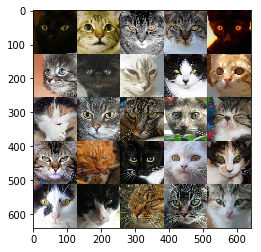

In [4]:
show_n_images = 25
mnist_images = helper.get_batch(glob(os.path.join(data_resized_dir, '*.jpg'))[:show_n_images], 64, 64, 'RGB')
plt.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## The DCGAN 🤖

In this part we're going to implement the DCGAN.
Our Architecture:<br><br>
<img src="assets/GDSchema.png" alt="Cat DCGAN Architecture"/>

Cat Icon made by <a href="https://www.flaticon.com/authors/vectors-market">  Vector Market </a> from www.flaticon.com 


### Check the version of Tensorflow and access to GPU

In [5]:
# Taken from Udacity face generator project
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0-dev20181012
Default GPU Device: /device:GPU:0


### Input
Create TF placeholders for the Neural Network:
- Real input images placeholder `real_dim`.
- Z input placeholder `z_dim`.
- Learning rate G placeholder.
- Learning rate D placeholder.
<br><br>
Return the placeholders in a tuple

In [6]:
def model_inputs(real_dim, z_dim):
    """
    Create the model inputs
    :param real_dim: tuple containing width, height and channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate G, learning rate D)
    """
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="learning_rate_G")
    learning_rate_D = tf.placeholder(tf.float32, name="learning_rate_D")
    
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D


### Generator Network

<img src="assets/generator.png" alt="Generator"/>


#### Variable Scope
Use tf.variable_scope <b> for 2 reasons </b>:
<ul>
    <li> Make sure all varaibles names start with generator / discriminator (will help out later when training the separate networks </li>
    <li> Also want <b> to reuse these networks with different inputs </b></li>
        <ul>
            <li> For the generator: we're going to train it but also <b>sample from it as we're training after training </b> </li>
            <li> For the discriminator: need to share variables between the fake and real input images </li>
    </ul>
</ul>
<p> So we can use the reuse keyword to <b> tell TensorFlow to reuse the var instead of createing new one if we build the graph again</b></p>

#### Leaky ReLU
Avoid gradient vanishing

#### Tanh Output
Generator has been found to perform the best <b> with tanh for the generator output </b>
<br>

- Leaky ReLU in all layers except for the last tanh layer
- Normalization on all the transposed convnets except the last one

<br>
<b>Transposed convnets --> normalization --> leaky ReLU</b>

In [7]:
def generator(z, output_channel_dim, is_train=True):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        output_channel_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope("generator", reuse= not is_train):
        
        # First FC layer --> 8x8x1024
        fc1 = tf.layers.dense(z, 8*8*1024)
        
        # Reshape it
        fc1 = tf.reshape(fc1, (-1, 8, 8, 1024))
        
        # Leaky ReLU
        fc1 = tf.nn.leaky_relu(fc1, alpha=alpha)

        
        # Transposed conv 1 --> BatchNorm --> LeakyReLU
        # 8x8x1024 --> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs = fc1,
                                  filters = 512,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv1")
        
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1, training=is_train, epsilon=1e-5, name="batch_trans_conv1")
       
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1, alpha=alpha, name="trans_conv1_out")
        
        
        # Transposed conv 2 --> BatchNorm --> LeakyReLU
        # 16x16x512 --> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs = trans_conv1_out,
                                  filters = 256,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv2")
        
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2, training=is_train, epsilon=1e-5, name="batch_trans_conv2")
       
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2, alpha=alpha, name="trans_conv2_out")
        
        
        # Transposed conv 3 --> BatchNorm --> LeakyReLU
        # 32x32x256 --> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs = trans_conv2_out,
                                  filters = 128,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv3")
        
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3, training=is_train, epsilon=1e-5, name="batch_trans_conv3")
       
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3, alpha=alpha, name="trans_conv3_out")

        
        # Transposed conv 4 --> BatchNorm --> LeakyReLU
        # 64x64x128 --> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs = trans_conv3_out,
                                  filters = 64,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv4")
        
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4, training=is_train, epsilon=1e-5, name="batch_trans_conv4")
       
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4, alpha=alpha, name="trans_conv4_out")

        
        # Transposed conv 5 --> tanh
        # 128x128x64 --> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs = trans_conv4_out,
                                  filters = 3,
                                  kernel_size = [5,5],
                                  strides = [1,1],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="logits")
         
        out = tf.tanh(logits, name="out")
        
        return out

### Discriminator
<img src="assets/discriminator.png" alt="Discriminator"/>

- Input is 128x128x3
- Depths starting with 32 and then *2 depth as you add layers
- No downsampling using only <b> strided conv layers with no maxpool layers </b>
- No batchnorm in input layer

<b> convolution > batch norm > leaky ReLU </b>

In [8]:
def discriminator(x, is_reuse=False, alpha = 0.2):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope("discriminator", reuse = is_reuse): 
        
        # Input layer 128*128*3 --> 64x64x64
        # Conv --> BatchNorm --> LeakyReLU   
        conv1 = tf.layers.conv2d(inputs = x,
                                filters = 64,
                                kernel_size = [5,5],
                                strides = [2,2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv1')
        
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')

        conv1_out = tf.nn.leaky_relu(batch_norm1, alpha=alpha, name="conv1_out")
        
        
        # 64x64x64--> 32x32x128
        # Conv --> BatchNorm --> LeakyReLU   
        conv2 = tf.layers.conv2d(inputs = conv1_out,
                                filters = 128,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv2')
        
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')
        
        conv2_out = tf.nn.leaky_relu(batch_norm2, alpha=alpha, name="conv2_out")

        
        
        # 32x32x128 --> 16x16x256
        # Conv --> BatchNorm --> LeakyReLU   
        conv3 = tf.layers.conv2d(inputs = conv2_out,
                                filters = 256,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv3')
        
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm3')
        
        conv3_out = tf.nn.leaky_relu(batch_norm3, alpha=alpha, name="conv3_out")

        
        
        # 16x16x256 --> 16x16x512
        # Conv --> BatchNorm --> LeakyReLU   
        conv4 = tf.layers.conv2d(inputs = conv3_out,
                                filters = 512,
                                kernel_size = [5, 5],
                                strides = [1, 1],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv4')
        
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm4')
        
        conv4_out = tf.nn.leaky_relu(batch_norm4, alpha=alpha, name="conv4_out")

        
        
        # 16x16x512 --> 8x8x1024
        # Conv --> BatchNorm --> LeakyReLU   
        conv5 = tf.layers.conv2d(inputs = conv4_out,
                                filters = 1024,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv5')
        
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm5')
        
        conv5_out = tf.nn.leaky_relu(batch_norm5, alpha=alpha, name="conv5_out")

         
        # Flatten it
        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        
        # Logits
        logits = tf.layers.dense(inputs = flatten,
                                units = 1,
                                activation = None)
        
        
        out = tf.sigmoid(logits)
        
        return out, logits

### Discriminator and generator losses

We train the g and d <b> at the same time </b> so we need losses for <b> both networks </b>

#### Discriminator Loss
Sum of loss for real and fake images
<br>
`d_loss = d_loss_real + d_loss_fake`
<br><br>
The losses will by <b> sigmoid cross entropy + wrap with tf.reduce_mean to get the mean for all the images in the batch.
</b>

##### Real image loss
- Use `d_logits_real` and labels <b> are all 1 (since all real data is real) </b>
- Label smoothing:  To help the discriminator generalize better, the labels are <b>reduced a bit from 1.0 to 0.9</b>
`labels = tf.ones_like(tensor) * (1 - smooth)`
For the real image loss, use the real logits and (smoothed) labels of ones. 

##### Fake image loss
- Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that
- For the fake image loss, use the fake logits with labels of all zeros

#### Generator Loss
- The generator loss again uses the fake logits from the discriminator, but this time the labels are all ones because the generator wants to fool the discriminator.

In [9]:
def model_loss(input_real, input_z, output_channel_dim, alpha):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator network here
    g_model = generator(input_z, output_channel_dim)   
    # g_model is the generator output
    
    # Discriminator network here
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,is_reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

### Optimizers
<ul>
    <li>Update the generator and discriminator <b>separately</b></li>
    <li> So we need to get the var for each part : we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph. </li>
</ul>
- The train operations are wrapped in a with tf.control_dependencies block so the batch normalization layers can update their population statistics.

In [10]:
def model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=lr_D, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=lr_G, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

## Training 🏃‍♂️
### Show output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, image_path, save, show):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param image_path: Path to save the image
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    
    if save == True:
        # Save image
        images_grid.save(image_path, 'JPEG')
    
    if show == True:
        plt.imshow(images_grid, cmap=cmap)
        plt.show()

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create our input placeholders
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], z_dim)
        
    # Losses
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3], alpha)
    
    # Optimizers
    d_opt, g_opt = model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1)
    
    i = 0
    losses = []
    samples = []
    version = "firstTrain"
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Saver
        saver = tf.train.Saver()
        
        num_epoch = 0
        
        if from_checkpoint == True:
            saver.restore(sess, "./models/model.ckpt")
            
            show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path, True, False)
            
        else:
            for epoch_i in range(epoch_count):        
                num_epoch += 1

                if num_epoch % 5 == 0:

                    # Save model every 5 epochs
                    #if not os.path.exists("models/" + version):
                    #    os.makedirs("models/" + version)
                    save_path = saver.save(sess, "./models/model.ckpt")
                    print("Model saved")

                for batch_images in get_batches(batch_size):
                    # Random noise
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    i += 1

                    # Run optimizers
                    _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D})
                    _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G})

                    if i % 10 == 0:
                        train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})
                        losses.append(train_loss_d)
                        losses.append(train_loss_g)
                        # Save it
                        image_name = str(i) + ".jpg"
                        image_path = "./images/" + image_name
                        samples.append(image_path)
                        show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path, True, False) 

                    # Print every 15 epochs (for stability overwize the jupyter notebook will bug)
                    if i % 1500 == 0:

                        image_name = str(i) + ".jpg"
                        image_path = "./images/" + image_name
                        print("Epoch {}/{}...".format(epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                        show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path, False, True)
                
            
                    
    return losses, samples

### Hyperparameters
Gans are <b> very sensitive to hyperparemeters </b>
In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [35]:
# Size input image for discriminator
real_size = (128,128,3)

# Size of latent vector to generator
z_dim = 100
learning_rate_D =  .00005 # Thanks to Alexia Jolicoeur Martineau https://ajolicoeur.wordpress.com/cats/
learning_rate_G = 2e-4 # Thanks to Alexia Jolicoeur Martineau https://ajolicoeur.wordpress.com/cats/
batch_size = 64
epochs = 215
alpha = 0.2
beta1 = 0.5

# Create the network
#model = DGAN(real_size, z_size, learning_rate, alpha, beta1)

Model saved
Model saved
Model saved
Epoch 15/215... Discriminator Loss: 1.4114... Generator Loss: 0.6629


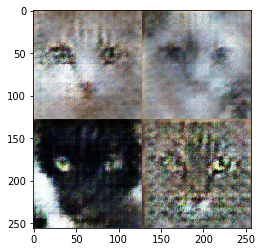

Model saved
Model saved
Model saved
Epoch 30/215... Discriminator Loss: 1.4038... Generator Loss: 0.6945


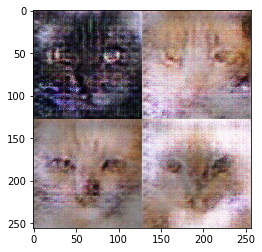

Model saved
Model saved
Model saved
Epoch 45/215... Discriminator Loss: 1.4455... Generator Loss: 0.5686


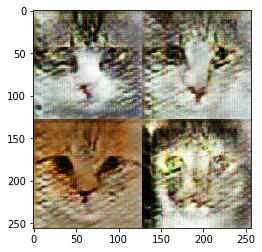

Model saved
Model saved
Model saved
Epoch 60/215... Discriminator Loss: 1.3862... Generator Loss: 0.6876


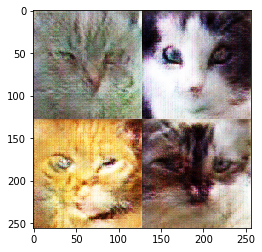

Model saved
Model saved
Model saved
Epoch 75/215... Discriminator Loss: 1.3239... Generator Loss: 0.6602


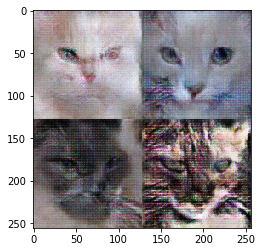

Model saved
Model saved
Model saved
Epoch 90/215... Discriminator Loss: 1.2172... Generator Loss: 0.5672


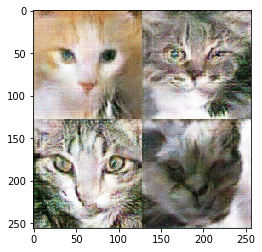

Model saved
Model saved
Model saved
Epoch 105/215... Discriminator Loss: 1.0246... Generator Loss: 1.0067


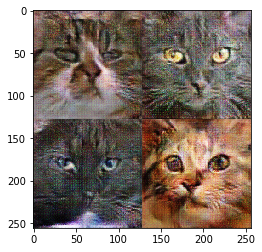

Model saved
Model saved
Model saved
Epoch 120/215... Discriminator Loss: 0.7827... Generator Loss: 0.9468


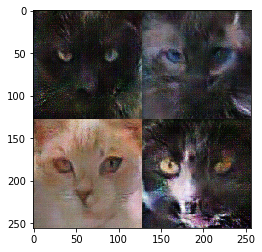

Model saved
Model saved
Model saved
Epoch 135/215... Discriminator Loss: 0.4640... Generator Loss: 1.4255


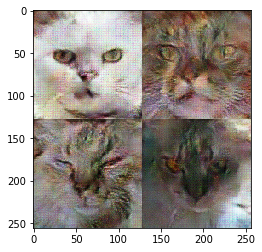

Model saved
Model saved
Model saved
Epoch 150/215... Discriminator Loss: 0.3292... Generator Loss: 2.9801


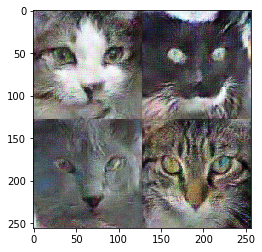

Model saved
Model saved
Model saved
Epoch 165/215... Discriminator Loss: 0.2389... Generator Loss: 2.4262


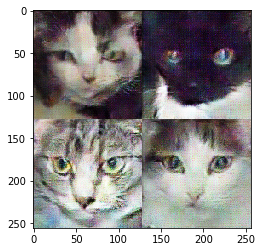

Model saved
Model saved
Model saved
Epoch 180/215... Discriminator Loss: 0.2069... Generator Loss: 2.4093


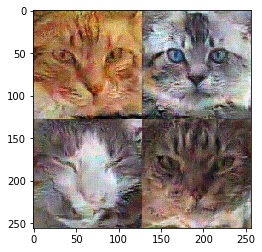

Model saved
Model saved
Model saved
Epoch 195/215... Discriminator Loss: 0.2296... Generator Loss: 2.3882


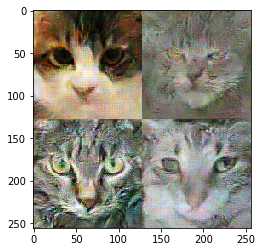

Model saved
Model saved
Model saved
Epoch 210/215... Discriminator Loss: 0.0973... Generator Loss: 3.0748


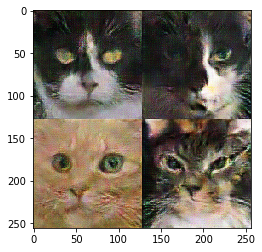

Model saved


In [36]:
# Load the data and train the network here
dataset = helper.Dataset(glob(os.path.join(data_resized_dir, '*.jpg')))
losses = []
samples = []
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, dataset.get_batches,
          dataset.shape, dataset.image_mode, alpha)

In [38]:
gen_loss = []
dis_loss = []
for i in range(len(losses)):
    if i%2 == 0:
        dis_loss.append(losses[i])
    else:
        gen_loss.append(losses[i])

## Training Loss 📈

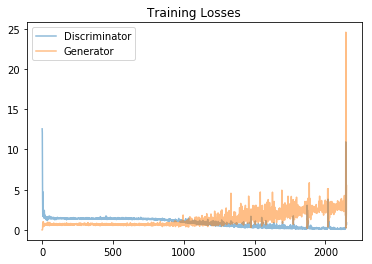

In [39]:
fig, ax = plt.subplots()
#losses = np.array(losses)
gen_loss = np.array(gen_loss)
dis_loss = np.array(dis_loss)
plt.plot(dis_loss, label='Discriminator', alpha=0.5)
plt.plot(gen_loss, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [19]:
vec = []
vec.append((1,2))
vec.append((3,4))
vec = np.array(vec)
print(vec.T[1])

[2 4]
